# Trading Interview Game

Now we have introduced CFR and understand the basics, lets try apply it to a problem inspired by a real interview question from a top quantitative trading firm.

## The Game - Part 1

The game starts with two players, both have to submit a number between 0 and 100 on a piece of paper. After the numbers are submitted, the papers are checked and whoever submitted the larger number must pay the other player their number. 

A few examples:
* Player A submits 90, Player B submits 10. Player B wins so receives \$10.
* Player A submits 15, Player B submits 20. Player A wins so receives \$15.
* Player A submits 1, Player B submits 99. Player A wins so receives \$1.

Imagine you are playing this game and versing an opponent who submits a random number between 1 and 100.
The warm-up question, which can be solved with just paper and pen, is to calculate the optimal number for you to submit, such that you maximise you expected value in this game. 




## Part 1 - Solution

Let $X$ be the number we submit. We can write the probability we win as 
$$
P(X) = 1 - \frac{X}{100}
$$
The payout when we win is simply $X$. The payout when we lose is the other players number. As this will be distributed uniformly between 0 and $X$, the loss will be on average, $X/2$. Therefore we write the expected value as
$$
\mathbb{E}(X) = X P(X) - \frac{X}{2} (1 - P(X)) = X - \frac{3 X^2}{200}
$$

Now we just solve for the maximum of this function (take derivative and set to zero) to get $X_0 = 33$.




## The Game - Part 2

Now we introduce a third player to the game who is perfectly rational, as are you, and there is still a player who submits a random bid. The penalty for losing a game is now greater, as the person who submits the highest number must now pay all the other players their number. If there is a tie for highest bid, they each pay half of the third players number.

For example:
* Player A submits 50, Player B submits 40, Player C submits 30. A loses so pays B \\$40 and pays C \\$30.
* Player A submits 20, Player B submits 50, Player C submits 50. B and C tie to lose, so both pay A \\$10 each.


Our previous strategy of picking a single number is no longer profitable as we will get exploited by the new player. It is likely we will now need to play a mixed strategy. Let's try solve this problem using CFR where we will find the nash equilibrium between player A and player B, and play this strategy to maximise our expected value. 

It is worth trying to solve this problem with just pen and paper too, as would be expected in an interview. We have therefore leftout the graph showing the answer and have it in the solutions document.

### Extension
In order to calculate a solution which converged fast enough, I had to use a slight modification on CFR called [CFR+](https://arxiv.org/pdf/1407.5042).

To check your nash equilibrium solution you can see how its EV compares to a pure strategy of choosing a single number. This is an easy way to check if you have made a mistake, as the nash strategy should beat all pure strategies. 

Further, you can compute the *exploitability* of a strategy to get a numerical value for the maximum theoretical exploitability of your strategy. You can also compare this to exploitability of pure strategies.

In [2]:
'''
I've commented out the naive implementation which is easier to understand and write at first.
Then I have vectorized the code for performance / good practice.
It is cool to see difference in performance we can acheive with numpy.
The naive implementation does 100 steps in ~2mins, while the vectorized does 10,000 steps in a few seconds, 
which is enough for this game to converge.
'''

import numpy as np
import matplotlib.pyplot as plt
N = 101
actions = np.arange(N)

In [3]:
'''
Tip: to speedup the computation, we can incorporate the randomness 
of player C's bid into our payoff function by taking an average over 
all 100 possible choices, instead of actually choosing a random number for player C.
'''

# hero number is first
def game_outcome(numbers: list[int]) -> int:
    m = max(numbers)
    max_index = [i for i, j in enumerate(numbers) if j == m]

    outcome = numbers.copy()

    if len(max_index) == 1:
        loss = m - sum(numbers)
        outcome[max_index[0]] = loss

        return outcome[0]

    if len(max_index) == 2:
        loss = m - sum(numbers) / 2
        outcome[max_index[0]] = loss
        outcome[max_index[1]] = loss

        return outcome[0]

    if len(max_index) == 3:
        return 0


In [4]:
'''
Tip: For further speedup, we can pre-cache all 100x100x100 = 1,000,000 game outcomes for this 3player game.
As we have to perform all 1,000,000 calculations each iteration, this reduces the time complexity of 
the algorithm from O(T) to O(1) where T is number of CFR steps. 
This is a technique which can be applied in all CFR algorithms to greatly speedup computation (at the cost of memory usage), 
and is essential for a production CFR implimentation.
'''

game_outcome_cache = np.zeros((N, N, N))

for i in actions:
    for j in actions:
        for k in actions:
            game_outcome_cache[i,j,k] = game_outcome([i,j,k])

In [5]:
'''
Action is the number to submit (101 possible actions)
'''

def payoff(hero_action: int, villain_strategy: np.array(float)) -> float:
    '''
    PAYOFF FUNCTION HERE
    '''
    # EV = 0
    # for i in actions:
    #     for j in actions:
    #         EV += game_outcome_cache[hero_action, i, j] * villain_strategy[i] / N

    EV = (game_outcome_cache[hero_action, :] * strategyA).sum() / N

    return EV

In [6]:
'''
Calculate immediate regret for every action
'''
def calculate_immediate_regret(hero_strategy: np.array(float), villain_strategy: np.array(float)) -> np.array(float):
    '''
    IMMEDIATE REGRET 
    '''
    # hero_EV = 0
    # for a in actions:
    #     hero_EV += hero_strategy[a] * payoff(a, villain_strategy)

    # regrets = np.zeros(N)
    
    # for a in actions:
    #     regrets[a] = payoff_array[a] - hero_EV

    payoff_array = np.vectorize(payoff)(actions, strategyA)
    hero_EV = (hero_strategy * payoff_array).sum()

    regrets = payoff_array - hero_EV

    return regrets



In [7]:

'''
Calculate new strategy based on accumulated regret for the hero
'''

def calculate_strategy(acc_regrets: np.array(float)) -> np.array(float):
    '''
    CALCULATE NEW STRATEGY
    '''
    positive_regret = np.where(acc_regrets > 0, acc_regrets, 0)

    normalisation = np.sum(positive_regret)

    if normalisation == 0:
        return np.ones(N) / N
        
    return positive_regret / normalisation
        


In [8]:
'''
We set initial strategy for both player A and B to pick uniformly from 0 to 100. 
'''

strategyA = np.ones(N) / N
strategyB = np.ones(N) / N

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

'''
Run CFR+ algorithm and save strategy history
'''

steps = 100000

strat_history_A = np.zeros((steps, N))
strat_history_B = np.zeros((steps, N))

for t in range(steps):
    acc_regretsA += calculate_immediate_regret(strategyA, strategyB)    
    strategyA = calculate_strategy(acc_regretsA)
    
    acc_regretsB += calculate_immediate_regret(strategyB, strategyA)
    strategyB = calculate_strategy(acc_regretsB)

    acc_regretsA[acc_regretsA < 0] = 0
    acc_regretsB[acc_regretsB < 0] = 0

    strat_history_A[t] = strategyA
    strat_history_B[t] = strategyB


In [9]:
'''
Perform weighted averaging of strategies to get nash solution according to CFR+
'''

weightings = np.arange(len(strat_history_A))

avg_strats_A = np.sum(strat_history_A * weightings[:, np.newaxis], axis=0)
avg_strats_B = np.sum(strat_history_B * weightings[:, np.newaxis], axis=0)

norm_A = np.sum(avg_strats_A)
norm_B = np.sum(avg_strats_A)

nash_strat_A = avg_strats_A / norm_A
nash_strat_B = avg_strats_B / norm_B


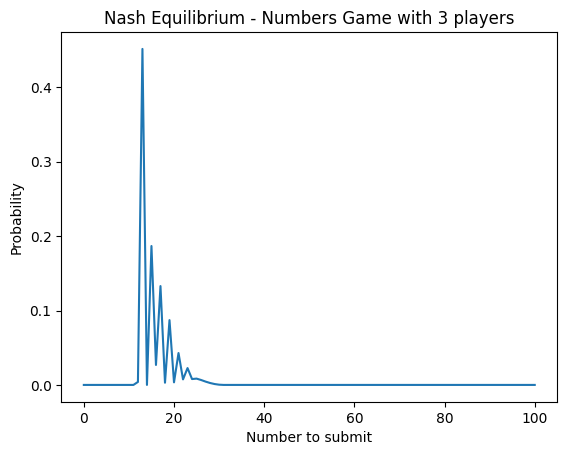

In [10]:
fig, ax = plt.subplots()

ax.plot(nash_strat_A)
# ax.plot(nash_strat_B)
ax.set_title('Nash Equilibrium - Numbers Game with 3 players')
ax.set_xlabel('Number to submit')
ax.set_ylabel('Probability')
# plt.show()
plt.savefig('figs/numbers_game_nash.png')

In [11]:
nash_EV = 0
for a in actions:
    nash_EV += nash_strat_A[a] * payoff(a, nash_strat_B)


pure_strat_EVs = []

for a in range(50):
    pure_strat = np.zeros(N)
    pure_strat[a] = 1
    
    pure_strat_EV = 0
    for a in actions:
        pure_strat_EV += pure_strat[a] * payoff(a, nash_strat_A)

    pure_strat_EVs.append(pure_strat_EV)


Nash EV = 11.9314


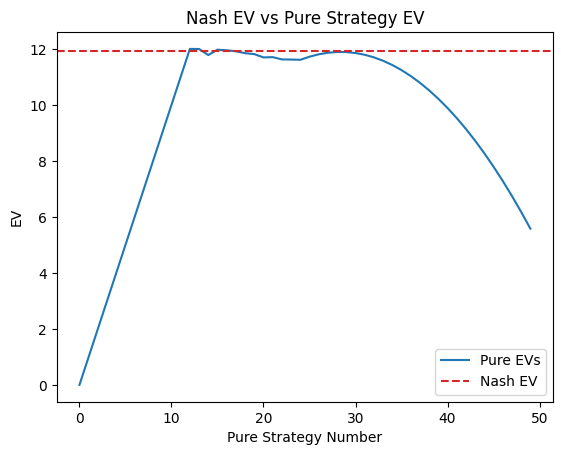

In [12]:
fig, ax = plt.subplots()

ax.plot(pure_strat_EVs, label = 'Pure EVs')
ax.axhline(nash_EV, linestyle='--', color='tab:red', label = 'Nash EV')
ax.legend()
ax.set_title('Nash EV vs Pure Strategy EV')
ax.set_xlabel('Pure Strategy Number') 
ax.set_ylabel('EV')
plt.savefig('figs/nash_vs_pure.png')
print(f"Nash EV = {nash_EV:.4f}")

In [13]:
nash_strat_A.cumsum()[12]*100

np.float64(0.40094713643714297)